In [45]:
using FFTW
using DSP

In [46]:
include("functions.jl")

estimate_time_delay (generic function with 1 method)

In [47]:
## Load the useful math operations
include("../modules/operations.jl");

In [48]:
# this is a 5G PRACH format 0 transmission
L=839

# this is number of samples per bin, floor(L/Ncs) gives the number of cyclic shifts, see below
Ncs=26
# this is the FFT size for the generation/reception of PRACH
N=49152
# this is the length of the cyclic prefix for PRACH
Ncp=6336

6336

In [49]:
# 6-bit data messages for 3 transmitters / UEs
preamble_index1=63;
preamble_index2=31;
preamble_index3=11;

# up to 6 Zadoff-Chu root sequences for this format
utab=[129 710 140 699 120 719]; @show length(utab);

length(utab) = 6


In [50]:
# number of cyclic shifts
nshifts = floor(Int, L / Ncs)
# number of Zadoff-Chu sequences required
nseq = ceil(Int, 64 / nshifts)


2

In [51]:
# index of the preamble sequence to use
uind1 = div(preamble_index1, nshifts)
uind2 = div(preamble_index2, nshifts)
uind3 = div(preamble_index3, nshifts)

# index of cyclic shift to use
nuind1 = rem(preamble_index1, nshifts)
nuind2 = rem(preamble_index2, nshifts)
nuind3 = rem(preamble_index3, nshifts)

# Check if indices are within the range of utab
if (uind1 >= length(utab) || uind2 >= length(utab) || uind3 >= length(utab))
    println("ERROR tab length ", length(utab), " : ", uind1, " ", uind2, " ", uind3)
end

In [52]:
# These are the Zadoff-Chu Sequence generators (time-domain) 
# for the 3 transmitters
xu1 = exp.(-im * π * utab[1 + uind1] * collect(0:838) .* collect(1:839) / 839)
xu2 = exp.(-im * π * utab[1 + uind2] * collect(0:838) .* collect(1:839) / 839)
xu3 = exp.(-im * π * utab[1 + uind3] * collect(0:838) .* collect(1:839) / 839)
@show size(xu1), size(xu2), size(xu3);

(size(xu1), size(xu2), size(xu3)) = ((839,), (839,), (839,))


In [53]:
# implement cyclic-shifts
# Note: In practice, it's not common to do cyclic shifts in the time-domain and then perform FFT.
# There is a way to compute the Fourier transform directly and then perform the cyclic shift by a multiplication of a phasor in the frequency-domain.

yuv1 = zeros(Complex{Float64}, length(xu1))
yuv2 = zeros(Complex{Float64}, length(xu2))
yuv3 = zeros(Complex{Float64}, length(xu3))

# Assuming length(xu1), length(xu2), and length(xu3) are known
xuv1 = zeros(ComplexF64, length(xu1))
xuv2 = zeros(ComplexF64, length(xu2))
xuv3 = zeros(ComplexF64, length(xu3))

for n = 0:838
    xuv1[n + 1] = xu1[1 + rem(n + (Ncs * nuind1), 839)]
    yuv1 .+= fft(xuv1)
    
    xuv2[n + 1] = xu2[1 + rem(n + (Ncs * nuind2), 839)]
    yuv2 .+= fft(xuv2)
    
    xuv3[n + 1] = xu3[1 + rem(n + (Ncs * nuind3), 839)]
    yuv3 .+= fft(xuv3)
end

In [54]:
# put the PRACH in the lowest frequency (positive) subcarriers starting at carrier 7
Xuv1 = zeros(Complex{Float64}, 49152)
Xuv1[7 .+ (1:839)] .= yuv1

Xuv2 = zeros(Complex{Float64}, 49152)
Xuv2[7 .+ (1:839)] .= yuv2

Xuv3 = zeros(Complex{Float64}, 49152)
Xuv3[7 .+ (1:839)] .= yuv3;

In [55]:
# bring to time-domain
xuv1_49152 = ifft(Xuv1)
xuv2_49152 = ifft(Xuv2)
xuv3_49152 = ifft(Xuv3)
@show size(xuv1_49152), size(xuv2_49152), size(xuv3_49152);

(size(xuv1_49152), size(xuv2_49152), size(xuv3_49152)) = ((49152,), (49152,), (49152,))


In [56]:
using Plots
using LinearAlgebra

In [57]:
# add cyclic prefix
xuv1_49152 = [xuv1_49152[(end - 6335):end]; xuv1_49152]
xuv2_49152 = [xuv2_49152[(end - 6335):end]; xuv2_49152]
xuv3_49152 = [xuv3_49152[(end - 6335):end]; xuv3_49152];

In [58]:
using StatsBase

In [59]:
# normalizes the transmit signal to unit-energy
xuv1_49152 /= sqrt(sum(abs2.(xuv1_49152)) / length(xuv1_49152))
en1 = mean(abs2.(xuv1_49152))
xuv2_49152 /= sqrt(sum(abs2.(xuv2_49152)) / length(xuv2_49152))
en2 = mean(abs2.(xuv2_49152))
xuv3_49152 /= sqrt(sum(abs2.(xuv3_49152)) / length(xuv3_49152))
en3 = mean(abs2.(xuv3_49152))

1.0

In [60]:
# simulate time-delay
delay1 = 300
delay2 = 140
delay3 = 40
delaymax = 1 + maximum([delay1, delay2, delay3])

xuv1_49152 = vcat( 
      vec(zeros(ComplexF64, 1, delay1)) 
    , xuv1_49152
    , vec(zeros(ComplexF64, 1, delaymax - delay1))
)
xuv2_49152 = vcat( 
      vec(zeros(ComplexF64, 1, delay2))
    , xuv2_49152
    , vec(zeros(ComplexF64, 1, delaymax - delay2))
)
xuv3_49152 = vcat( 
      vec(zeros(ComplexF64, 1, delay3))
    , xuv3_49152
    , vec(zeros(ComplexF64, 1, delaymax - delay3))
)
@show length(xuv1_49152), length(xuv2_49152), length(xuv3_49152);

(length(xuv1_49152), length(xuv2_49152), length(xuv3_49152)) = (55789, 55789, 55789)


In [61]:
using Random

In [62]:
SNR = 0
snr = 10^(0.1 * SNR)

# Generate complex Gaussian noise
noise1 = sqrt(0.5 / snr) * (randn(Complex{Float64}, length(xuv1_49152)) + 1im * randn(Complex{Float64}, length(xuv1_49152)))
noise2 = sqrt(0.5 / snr) * (randn(Complex{Float64}, length(xuv1_49152)) + 1im * randn(Complex{Float64}, length(xuv1_49152)));

In [63]:
# Add noise to signals
rxsig1_justnoise = xuv1_49152 + noise1
rxsig2_justnoise = xuv1_49152 + xuv2_49152 + xuv3_49152 + noise2;

In [125]:
rxsig1_justnoise_plot =
plot(10 * log10.(abs.(rxsig1_justnoise))
    , size = ( 800, 300 )
    , linewidth = .2
)
savefig(rxsig1_justnoise_plot, "images/rxsig1_justnoise_plot.png");

<img src=images/rxsig1_justnoise_plot.png width='' height='' > </img>

In [126]:
rxsig2_justnoise_plot =
plot(10 * log10.(abs.(rxsig2_justnoise))
    , size = ( 800, 300 )
    , linewidth = .2
)
savefig(rxsig2_justnoise_plot, "images/rxsig2_justnoise_plot.png");

<img src=images/rxsig2_justnoise_plot.png width='' height='' > </img>

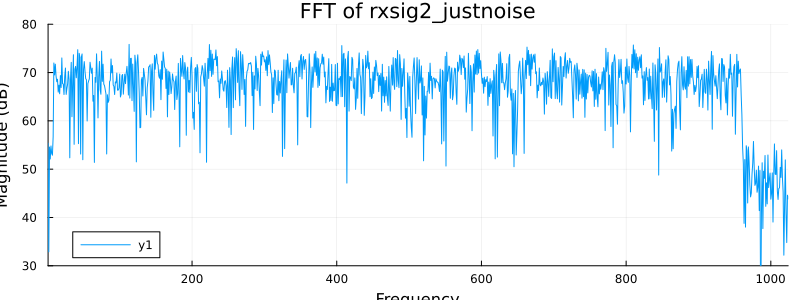

In [127]:
plot(20 * log10.(abs.(fft(rxsig2_justnoise)))
    , xlabel="Frequency", ylabel="Magnitude (dB)"
    , title="FFT of rxsig2_justnoise"
    , xlims = (1, 1024), ylims = (30, 80)
    , size = ( 800, 300 )
)

#### Question: What can you say regarding the frequency span (approximately how many PRBs does this waveform occupy

In [128]:
include("get_tld.jl");

In [129]:
fs = 61.44e6
SCS = 30e3
DS = 300e-9

3.0e-7

In [130]:
H1 = get_tdl(fs, SCS, 0:105, DS, "tdlc")
H2 = get_tdl(fs, SCS, 0:105, DS, "tdlc")
H3 = get_tdl(fs, SCS, 0:105, DS, "tdlc"); @show typeof(H1);

typeof(H1) = Vector{Vector{ComplexF64}}


In [131]:
## Prepare the template signal for convolution
H1̅ = ⦰(H1[1]); # reverse #typed H\overbar
H1̅ᴴ = conj(H1̅); # conjugate 
@show length(H1̅ᴴ);

length(H1̅ᴴ) = 24


In [132]:
rxsig3_noiseandchannel = H1̅ᴴ ⊗ xuv1_49152
rxsig3_noiseandchannel .= rxsig3_noiseandchannel .+ sqrt(0.5 / snr) * (randn(ComplexF64, length(rxsig3_noiseandchannel)) + 1im * randn(ComplexF64, length(rxsig3_noiseandchannel)));

In [133]:
# Plot the result
rxsig3_noiseandchannel_plot = 
plot(10 * log10.(abs.(rxsig3_noiseandchannel))
    , xlabel="Sample"
    , ylabel="Power (dB)"
    , title="Convolution Result"
    # , ylim=(-20, 60)
    , size = (800, 300)
    , linewidth = .5
)
savefig(rxsig3_noiseandchannel_plot,"images/rxsig3_noiseandchannel_plot.png");

<img src=images/rxsig3_noiseandchannel_plot.png width='' height='' > </img>

In [134]:
## Prepare the template signal for convolution
H2̅ = ⦰(H2[1]); # reverse #typed H\overbar
H2̅ᴴ = conj(H2̅); # conjugate 
@show length(H2̅ᴴ);

## Prepare the template signal for convolution
H3̅ = ⦰(H3[1]); # reverse #typed H\overbar
H3̅ᴴ = conj(H3̅); # conjugate 
@show length(H3̅ᴴ);

length(H2̅ᴴ) = 24
length(H3̅ᴴ) = 24


In [135]:
rxsig4_noiseandchannel = (H1̅ᴴ ⊗ xuv1_49152) .+ (H2̅ᴴ ⊗ xuv2_49152) .+ (H3̅ᴴ ⊗ xuv3_49152)
rxsig4_noiseandchannel .= rxsig4_noiseandchannel .+ sqrt(0.5 / snr) * (randn(ComplexF64, length(rxsig4_noiseandchannel)) + 1im * randn(ComplexF64, length(rxsig4_noiseandchannel)));

In [136]:
# Plot the result
rxsig4_noiseandchannel_plot = 
plot(10 * log10.(abs.(rxsig4_noiseandchannel))
    , xlabel="Sample"
    , ylabel="Power (dB)"
    , title="Convolution Result"
    # , ylim=(-20, 60)
    , size = ( 800, 300 )
    , linewidth = .5
)
savefig(rxsig4_noiseandchannel_plot,"images/rxsig4_noiseandchannel_plot.png");

<img src=images/rxsig4_noiseandchannel_plot.png width='' height='' > </img>

What to do now

a) implement the receiver using a frequency-domain correlation

   using the Zadoff-Chu sequences generation method as above

b) show how the data detection and time-delay estimation

In [137]:
# rxsig1_noprefix = rxsig1_justnoise[6636:6636+49151]
# rxsig2_noprefix = rxsig2_justnoise[6636:6636+49151];
rxsig1_noprefix = rxsig3_noiseandchannel[6636:6636+49151]
rxsig2_noprefix = rxsig4_noiseandchannel[6636:6636+49151];

In [138]:
RXSIG1 = fft(rxsig1_noprefix);
RXSIG2 = fft(rxsig2_noprefix);

In [139]:
utab[1]

129

In [140]:
# correlation with preamble sequence with nu=0 for each sequence

nseq = length(utab)
Xu = zeros(ComplexF64, nseq, L)
Ru1 = similar(Xu)
Ru2 = similar(Xu)
ru1 = similar(Xu)
ru2 = similar(Xu)

for seq in 1:nseq
    # Compute time-domain ZC sequence for each u in 1:nseq
    xun = exp.(-1.0im * π * utab[seq] * (0:838) .* (1:839) / 839)#; @show typeof(xun)#, xun
    
    # Compute freq-domain ZC sequence for each u in 1:nseq
    Xu[seq,:] = fft(xun)
    
    # Correlate (componentwise multiplication and IFFT) with received signal
    Ru1[seq, :] = RXSIG1[7 .+ (1:L)] .* conj(Xu[seq, :])
    Ru2[seq, :] = RXSIG2[7 .+ (1:L)] .* conj(Xu[seq, :])
    ru1[seq, :] = ifft(Ru1[seq, :])
    ru2[seq, :] = ifft(Ru2[seq, :])
end


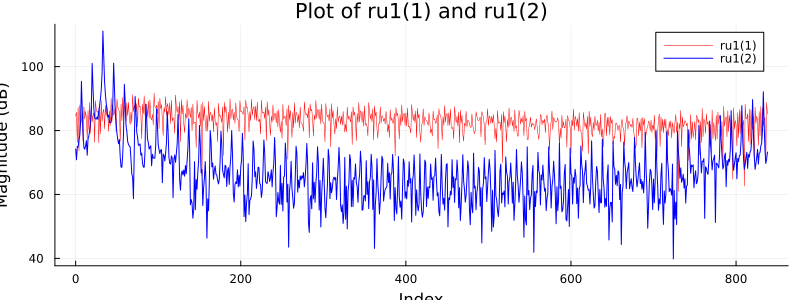

In [141]:
plot(0:838, 20 * log10.(abs.(ru1[1, :]))
    , label="ru1(1)", color=:red
    , xlabel = "Index", ylabel = "Magnitude (dB)"
    , title = "Plot of ru1(1) and ru1(2)"
    , size = (800, 300)
    , linewidth = .5
)
plot!(0:838, 20 * log10.(abs.(ru1[2, :]))
    , label="ru1(2)", color=:blue
    , linewidth = 1
)

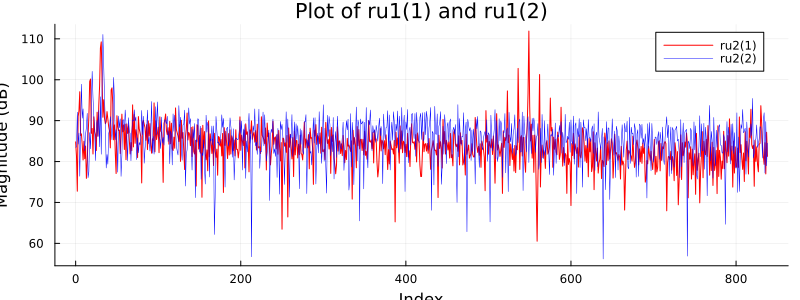

In [142]:
plot(0:838, 20 * log10.(abs.(ru2[1, :]))
    , label="ru2(1)", color=:red
    , xlabel = "Index", ylabel = "Magnitude (dB)"
    , title = "Plot of ru1(1) and ru1(2)"
    , size = (800, 300)
    , linewidth = 1
)
plot!(0:838, 20 * log10.(abs.(ru2[2, :]))
    , label="ru2(2)", color=:blue
    , linewidth = .5
)